# Using Convolutional Autoencoder to extract features

In [1]:
import tensorflow as tf
import numpy as np
import math
import scipy.io as sio

In [2]:
data  = sio.loadmat('../distorted_MNIST.mat')

In [3]:
train_X = data['train_X']
train_y = data['train_y']
test_X = data['test_X']

In [4]:
X = np.concatenate((train_X, test_X))
X = X.reshape(-1,28,28,1)

In [5]:
X.shape

(50000, 28, 28, 1)

## define computation graph for cae model

### encoder part

In [6]:
NUM_HIDDEN = 50
input_shape = [None, 28, 28, 1]
x = tf.placeholder(tf.float32, input_shape, name='x')
n_filters = [1,32,32]
filter_sizes=[3, 3]
shapes = []
current_input = x
for layer_i, n_output in enumerate(n_filters[1:]):
    n_input = current_input.get_shape().as_list()[3]
    shapes.append(current_input.get_shape().as_list())
    W = tf.Variable(
            tf.truncated_normal([
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input, n_output],
                stddev=1.0 / math.sqrt(n_input)))
    b = tf.Variable(tf.zeros([n_output])+0.1)
    output = tf.nn.relu(
                tf.add(tf.nn.conv2d(
                    current_input, W, strides=[1, 2, 2, 1], padding='SAME'), b))
    current_input = output

n_input = np.prod(current_input.get_shape().as_list()[1:])
current_input = tf.reshape(output,[-1,n_input])
W = tf.Variable(
            tf.truncated_normal([n_input, NUM_HIDDEN],
                stddev=1.0 / math.sqrt(n_input)))
b = tf.Variable(tf.zeros([NUM_HIDDEN])+0.1)
features = tf.nn.relu(tf.add(tf.matmul(current_input, W),b))


In [7]:
output.get_shape().as_list()

[None, 7, 7, 32]

### decoder part

In [8]:
n_output = np.prod(output.get_shape().as_list()[1:])
W = tf.Variable(tf.truncated_normal([NUM_HIDDEN, n_output],
                stddev=1.0 / math.sqrt(NUM_HIDDEN)))
b = tf.Variable(tf.zeros([n_output])+0.1)
output = tf.nn.relu(tf.add(tf.matmul(features,W),b))
current_input = tf.reshape(output, [-1,7,7,32])

shapes.reverse()

for layer_i, shape in enumerate(shapes):
    W = tf.Variable(
            tf.truncated_normal([
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_filters[-2-layer_i], n_filters[-1-layer_i]],
                stddev=1.0 / math.sqrt(n_filters[-1-layer_i])))
    b = tf.Variable(tf.zeros([W.get_shape().as_list()[2]])+0.1)
    if layer_i < len(shapes)-1:
        activation_func = tf.nn.relu
    else:
        activation_func = tf.nn.sigmoid
    output = activation_func(tf.add(
            tf.nn.conv2d_transpose(
                current_input, W,
                tf.pack([tf.shape(x)[0], shape[1], shape[2], shape[3]]),
                strides=[1, 2, 2, 1], padding='SAME'), b))
    current_input = output
y = current_input
# cost function measures pixel-wise difference
cost = tf.reduce_mean(tf.square(y - x))

# create a saver
saver = tf.train.Saver()

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

## training the model

In [10]:
mean_img = np.mean(X, axis=0)

    # %%
learning_rate = 1
optimizer = tf.train.AdadeltaOptimizer(learning_rate).minimize(cost)

    # %%
    # We create a session to use the graph
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

    # %%
    # Fit all training data
batch_size = 500
n_epochs = 200
for epoch_i in range(n_epochs):
    for batch_i in range(50000 // batch_size):
        batch_xs = X[batch_i*batch_size:(batch_i+1)*batch_size,:,:,:]
        train = np.array([img - mean_img for img in batch_xs])
        sess.run(optimizer, feed_dict={x: train})
    if epoch_i % 100 ==99:
        saver.save(sess, 'CAE_on_distorted_MNIST', global_step=epoch_i)
    print(epoch_i, sess.run(cost, feed_dict={x: train}))

0 0.0704251
1 0.0703663
2 0.0703529
3 0.0703471
4 0.0703437
5 0.0703412
6 0.070339
7 0.0703368
8 0.0703341
9 0.0703302
10 0.0703239
11 0.0703152
12 0.0703026
13 0.0702835
14 0.0702603
15 0.0702341
16 0.0702063
17 0.070176
18 0.0701414
19 0.0701004
20 0.0700475
21 0.069973
22 0.0698533
23 0.0696134
24 0.0692274
25 0.0687063
26 0.0679435
27 0.0668767
28 0.0653967
29 0.063423
30 0.0608358
31 0.0576401
32 0.0541832
33 0.0515408
34 0.049383
35 0.0474371
36 0.0459327
37 0.0444033
38 0.0422669
39 0.0409192
40 0.0391425
41 0.0379647
42 0.0371116
43 0.0363847
44 0.0363403
45 0.0355012
46 0.0350394
47 0.0345614
48 0.0338001
49 0.0338341
50 0.0331538
51 0.0324322
52 0.0320711
53 0.0317294
54 0.0311301
55 0.031301
56 0.0310197
57 0.0312539
58 0.0310416
59 0.0307638
60 0.0299468
61 0.0307421
62 0.0297833
63 0.0295593
64 0.0292725
65 0.0293712
66 0.0294308
67 0.0290115
68 0.028768
69 0.0287353
70 0.0286943
71 0.0284035
72 0.0283039
73 0.0284077
74 0.0279698
75 0.0282035
76 0.0280628
77 0.0280449
78 

# plot the reconstructed images

(10, 28, 28, 1)


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


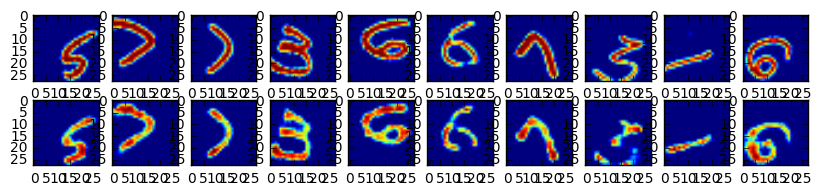

In [11]:
# %%
# Plot example reconstructions
n_examples = 10
test_xs = X[:n_examples]
test_xs_norm = np.array([img - mean_img for img in test_xs])
recon = sess.run(y, feed_dict={x: test_xs_norm})
print(recon.shape)
fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))

for example_i in range(n_examples):
    axs[0][example_i].imshow(np.reshape(test_xs[example_i, :], (28, 28)))
    axs[1][example_i].imshow(np.reshape(recon[example_i, :],(28, 28)))
fig.show()
plt.draw()

# We human can read these reconstructed images, which means the NUM_HIDDEN dimensional representation should contain enough information for classification. 

In [68]:
X_encode = np.zeros((50000,NUM_HIDDEN), dtype=np.float32)
for batch_i in range(50000 // batch_size):
    batch_xs = X[batch_i*batch_size:(batch_i+1)*batch_size,:,:,:]
    train = np.array([img - mean_img for img in batch_xs])
    encoded_feature = sess.run(features, feed_dict={x: train})
    X_encode[batch_i*batch_size:(batch_i+1)*batch_size,:] = encoded_feature

In [69]:
X_encode.shape

(50000, 50)

In [62]:
sio.savemat("X_encode.mat", {'X_encode':X_encode})

In [15]:
X_encode = sio.loadmat('X_encode.mat')['X_encode']

In [16]:
import sklearn.neighbors
from sklearn.decomposition import PCA
KNN_C = sklearn.neighbors.KNeighborsClassifier()

def train_and_eval( model, train_x, train_y, test_x, test_y):
    model.fit( train_x, train_y )
    p = model.predict( test_x )
    OA = sum(test_y==p)/len(test_y)
    return OA
test_data = sio.loadmat('../testset_label.mat')
test_y = test_data['test_y']
train_y = train_y.flatten()
test_y = test_y.flatten()

## accuracy

In [17]:
train_and_eval(KNN_C, X_encode[:10000,:], train_y, X_encode[10000:,:], test_y)

0.74262499999999998

## fine tune the model to get better result

In [12]:
learning_rate = 0.2
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
batch_size = 500
n_epochs = 200
for epoch_i in range(n_epochs):
    for batch_i in range(50000 // batch_size):
        batch_xs = X[batch_i*batch_size:(batch_i+1)*batch_size,:,:,:]
        train = np.array([img - mean_img for img in batch_xs])
        sess.run(optimizer, feed_dict={x: train})
    print(epoch_i, sess.run(cost, feed_dict={x: train}))

0 0.0235546
1 0.0235506
2 0.0235467
3 0.0235429
4 0.0235392
5 0.0235354
6 0.0235318
7 0.0235281
8 0.0235245
9 0.023521
10 0.0235176
11 0.0235143
12 0.0235109
13 0.0235077
14 0.0235045
15 0.0235013
16 0.0234982
17 0.0234952
18 0.0234921
19 0.0234891
20 0.0234861
21 0.0234831
22 0.02348
23 0.023477
24 0.023474
25 0.023471
26 0.0234681
27 0.0234651
28 0.0234622
29 0.0234594
30 0.0234565
31 0.0234537
32 0.0234508
33 0.0234479
34 0.0234451
35 0.0234422
36 0.0234394
37 0.0234366
38 0.0234339
39 0.0234311
40 0.0234283
41 0.0234255
42 0.0234228
43 0.0234201
44 0.0234174
45 0.0234147
46 0.023412
47 0.0234093
48 0.0234067
49 0.023404
50 0.0234013
51 0.0233987
52 0.023396
53 0.0233934
54 0.0233907
55 0.0233881
56 0.0233854
57 0.0233828
58 0.0233802
59 0.0233775
60 0.0233749
61 0.0233722
62 0.0233696
63 0.023367
64 0.0233644
65 0.0233618
66 0.0233592
67 0.0233566
68 0.023354
69 0.0233514
70 0.0233488
71 0.0233463
72 0.0233437
73 0.0233412
74 0.0233386
75 0.023336
76 0.0233334
77 0.0233309
78 0.023